In [1]:
# this enable automatic reloading of libraries
%load_ext autoreload
%autoreload 2

from clib.bellhop import *
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

1 grid file found, uses: /home/datawork-lops-osi/jgula/NESED/nesea_grd.nc
-- Grid object
dim lon_rho: 1602  2002
lon_rho min= -72.123, max=-58.273
lat_rho min= 34.123, max=43.734
h min= 20.000, max=5543.070
Uses the following output file: /home/datawork-lops-osi/jgula/NESED/nesed_avg.00060.nc
The transect will contain 216 horizontal points


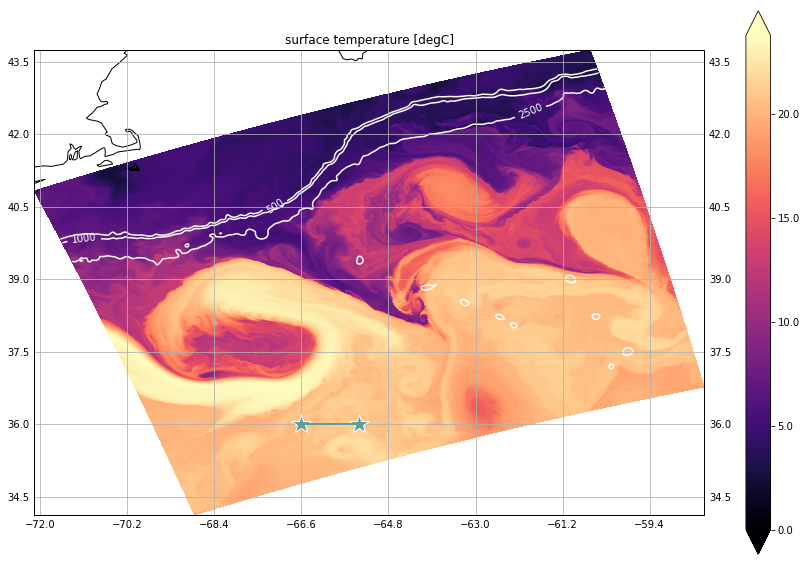

In [2]:
s = bellhop({'gs': {'datadir': '/home/datawork-lops-osi/jgula/NESED/', 'lon': [-66.6,-65.4], \
                    'lat': [36.,36.], 'plot_map': True, 'contour':True}}, zmax = 4900)

# SSP profiles

In [3]:
r = s.SSP['gs']['s']              # range (m)
depth = s.SSP['gs']['depth'][:]   # depth (m)
c = s.SSP['gs']['c']              # celerity (m/s)
print('Number of values for each profile :', c.shape[1])
print('Number of celerity profiles :', c.shape[0])
print('Maximum range : %.1fkm' %(np.max(r)/1000.))

Number of values for each profile : 50
Number of celerity profiles : 216
Maximum range : 107.8km


# Generate .env file (A)

- *Bathymetry* : flat bottom at 4500 m depth

- *Source* : one source at 100m depth at range 0km

- *Receivers* : **Depth : every 1m from 0 to 500m depth    /    Range : every 10m from 0 to 100 km **


In [4]:
# Generate .env file A
issp=0                                # sound speed profile number

s.params['hypothesis'] = 'QVWT'       # Q for quadrilateral SSP interpolation (SSP2D)
s.params['file_type'] = 'A'           # 'E' : eigen rays (.rau) / 'A' : arrivals time and amplitude file (.arr)
s.params['zs'] = 100.                 # source depth
s.params['ALimites'] = [-89.0, 89.0]  # limit angles

s.params['NDepth'] = 501              # number of receiver depths
s.params['zmin'] = 0.                 # minimum depth (m)
s.params['zmax'] = 500.               # maximum depth (m) (unuseful if NDepth=1)
                 
s.params['NRange'] = 10001            # number of receiver range    
s.params['rmin'] = 0.                 # minimum range (km)
s.params['rmax'] = 100.               # maximum range (km) (unuseful if NRange=1)            

s.params['zbox'] = 5000.              # box depth limit 
s.params['rbox'] = 101.               # box range limit 

s.generate_envfile('gs',file_env = 'gs_2D_A.env', Issp=issp, SSP_depth_step=1)

# Generate .ssp file

In [5]:
s.generate_sspfile('gs', file_env='gs_2D_A.env', SSP_depth_step=1)

Output file is : gs_2D_A.ssp


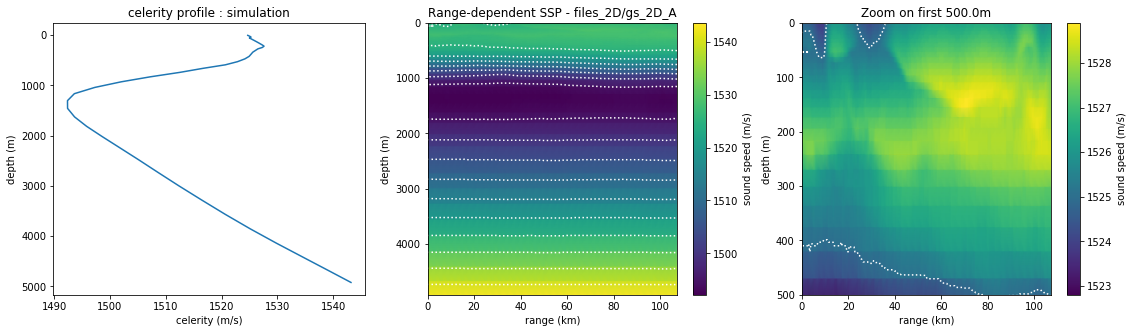

In [6]:
plt.figure(figsize=(19,5))
plt.subplot(131)
s.plotssp ('gs', Issp=0, zoom=False)
plt.subplot(132)
s.plotssp2D('files_2D/gs_2D_A.ssp')
plt.subplot(133)
s.plotssp2D('files_2D/gs_2D_A.ssp', zoom = 550.)
plt.show()

In [7]:
Temp = np.flipud(s.SSP['gs']['Temp'])
Sal = np.flipud(s.SSP['gs']['Sal'])

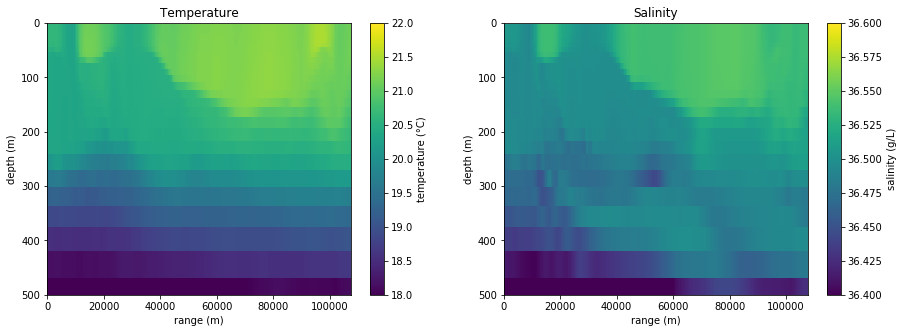

In [8]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.pcolormesh(r, depth, Temp)
plt.title ('Temperature')
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("temperature (°C)")
plt.ylim([0,500])
plt.clim([18.,22.])
plt.gca().invert_yaxis()

plt.subplot(122)
plt.pcolormesh(r, depth, Sal)
plt.title ('Salinity')
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("salinity (g/L)")
plt.ylim([0,500])
plt.clim([36.4,36.6])
plt.gca().invert_yaxis()
plt.show()

---
# Arrival calculations

In [9]:
### read file .arr 
#Arr, Pos = s.read_arrivals_asc ('gs_2D_A.arr', Narrmx = 15)
#s.save_dict('../Dictio', Arr, 'Arr_gs_SSP2D')
#s.save_dict('../Dictio', Pos, 'Pos_gs_SSP2D')
Arr, Pos = s.load_dict('../Dictio', 'Arr_gs_SSP2D'), s.load_dict('../Dictio', 'Pos_gs_SSP2D')

In [10]:
Nsd = np.shape(Pos['s']['depth'])[0]
Nrd = np.shape(Pos['r']['depth'])[0]
Nrr = np.shape(Pos['r']['range'])[0]

print('Number of source depths   : Nsd = ', Nsd)
print('Number of receiver depths : Nrd = ', Nrd)
print('Number of receiver ranges : Nrr = ', Nrr)

print ('\nTotal number of receivers : ', Nrr*Nrd)

Number of source depths   : Nsd =  1
Number of receiver depths : Nrd =  501
Number of receiver ranges : Nrr =  10001

Total number of receivers :  5010501


---
# Arrival times tables 

In [70]:
### sonar equation
SL = 185                 # Souce level (dB)
NL = 81.7                # Noise level (dB)
DI = 0                   # Directivity index (dB)
B = 200                  # bandwidth (Hz)
T = 1                    # transmitted signal duration (s)
PG = 10.0*np.log10(B*T)  # Processing gain (dB)

#RT  = SL - TL - NL + DI + PG 
seuil_d = 10.

In [12]:
# Create time table from bellhop output data. Based on detection treshold method.
def time_table (Arr) :
    T = np.zeros( (Nrr, Nrd, Nsd) )
    for isd1 in range (Nsd):
        for ird1 in range (Nrd) : 
            for irr1 in range (Nrr) :
                Narr = int(Arr['Narr'][irr1, ird1, isd1])
                if not Narr ==0 :
                    A = abs(Arr['A'][irr1, :Narr, ird1, isd1])  # amplitude 
                    TL = - 20.0*np.log10(A)
                    RL = SL - TL - NL +DI + PG    # received level 
                    t = Arr['delay'][irr1, :Narr, ird1, isd1]
                    t_ok = t[np.where(RL > seuil_d)]

                    if len(t_ok > 0): 
                        t_min = np.min(t_ok)
                        T[irr1,ird1,isd1] = t_min  
                    else : 
                        T[irr1,ird1,isd1] = np.NaN
                else : 
                    T[irr1,ird1,isd1] = np.NaN
    return (T)

---
### 1 - True arrival times

In [13]:
#T_true = time_table(Arr)
#np.save('T_true', T_true)
T_true = np.load ('NPY_2D/T_true.npy')

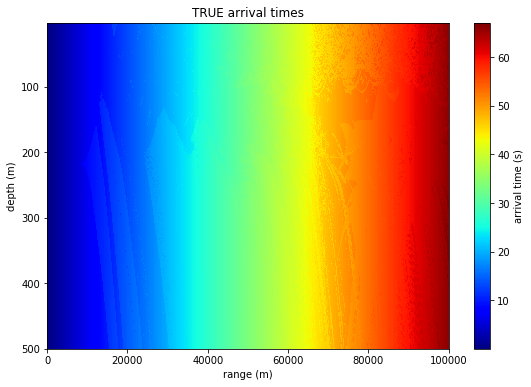

In [14]:
isd = 0    # source number (only 1 source here)
R = Pos['r']['range']
Z = Pos['r']['depth']
plt.figure(figsize=(9,6))
plt.pcolormesh(R, Z, T_true[:,:,isd].T, cmap='jet')
plt.title ('TRUE arrival times')
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("arrival time (s)")
plt.gca().invert_yaxis()

---
### 2 - One profile (at range 50km) arrival times

In [15]:
### Generate .env file A
#s.params['hypothesis'] = 'SVWT' 
#s.generate_envfile('gs',file_env = 'gs_1prof_A.env', Issp=issp, SSP_depth_step=1, c = c[100,:])

In [16]:
### read file .arr 
#Arr_1prof, Pos_1prof = s.read_arrivals_asc ('gs_1prof_A.arr', Narrmx = 15)
Arr_1prof, Pos_1prof = s.load_dict('../Dictio', 'Arr_gs_1prof'), s.load_dict('../Dictio', 'Pos_gs_1prof')

In [17]:
#T_1prof = time_table(Arr_1prof)
#np.save('T_1prof', T_1prof)
T_1prof = np.load('NPY_2D/T_1prof.npy')

---
# Comparison and error on distance 

In [44]:
diff_1prof = T_true - T_1prof
celerity = 1500. 
dx = diff_1prof * celerity

dx < 10m : 35.5%
10m < dx < 50m : 13.3%
dx > 50m : 51.2%


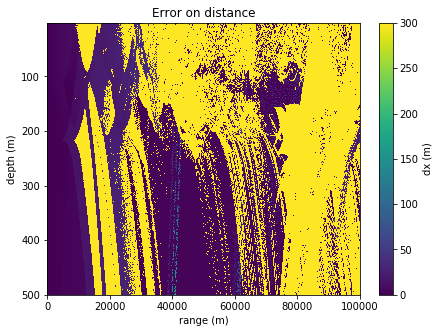

In [45]:
# dx table
plt.figure(figsize=(7,5))
plt.pcolormesh(R, Z, abs(dx[:,:,isd]).T) #, cmap='jet')
plt.title ('Error on distance')
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("dx (m)")
plt.clim([0,300])
plt.gca().invert_yaxis()

# Pourcents
tot = dx.shape[0]*dx.shape[1]
under10 = np.where(abs(dx) <10.)[0].shape[0]
under50 = np.where(np.logical_and(abs(dx) >=10., abs(dx) < 50.))[0].shape[0]
over50  = np.where(abs(dx) >= 50.)[0].shape[0]
print ('dx < 10m : %.1f' %(under10/tot*100.) + '%')
print ('10m < dx < 50m : %.1f' %(under50/tot*100.) + '%')
print ('dx > 50m : %.1f' %(over50/tot*100.) + '%')


---
### Ray comparison 

In [22]:
# TRUE : Generate .env and .ssp file R
s.params['NBeams'] = 20
s.params['hypothesis'] = 'QVWT'       # Q for quadrilateral SSP interpolation (SSP2D)
s.params['file_type'] = 'R'
s.params['ALimites'] = [-7,7]
s.generate_envfile('gs',file_env = 'gs_2D_R.env', Issp=issp, SSP_depth_step=1)
s.generate_sspfile('gs', file_env='gs_2D_R.env', SSP_depth_step=1)

### 1profile : Generate .env file R
s.params['hypothesis'] = 'SVWT' 
s.generate_envfile('gs',file_env = 'gs_1prof_R.env', Issp=issp, SSP_depth_step=1, c = c[100,:])

Output file is : gs_2D_R.ssp


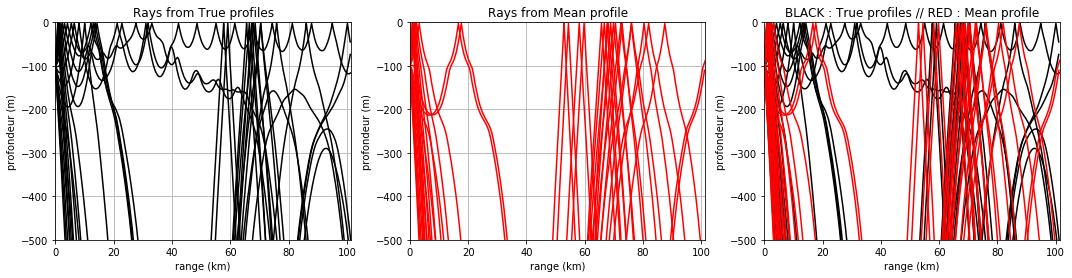

In [23]:
plt.figure(figsize=(18,4))
plt.subplot(131)
s.plotray('files_2D/gs_2D_R.ray', colors='k', zoom=True)
plt.title('Rays from True profiles')
plt.subplot(132)
s.plotray('files_2D/gs_1prof_R.ray', colors='r', zoom=True)
plt.title('Rays from Mean profile')
plt.subplot(133)
s.plotray('files_2D/gs_2D_R.ray', colors='k', zoom=True)
s.plotray('files_2D/gs_1prof_R.ray', colors='r', zoom=True)
plt.title('BLACK : True profiles // RED : Mean profile')
plt.show()

---
# With 3 profiles (one every 50km)

In [24]:
# ranges 0km, 50km and 107km 
c_3profiles = np.vstack((c[0,:],c[100,:],c[215,:]))
r_3profiles = np.array([r[0], r[100], r[215]]) 

In [25]:
# Generate .env file A and .ssp file
s.params['hypothesis'] = 'QVWT'
s.generate_envfile('gs',file_env = 'gs_2D_A_3prof.env', Issp=issp, SSP_depth_step=1, c = c_3profiles[0,:])
s.generate_sspfile('gs', file_env='gs_2D_A_3prof.env', SSP_depth_step=1, r = r_3profiles, c = c_3profiles)

Output file is : gs_2D_A_3prof.ssp


In [26]:
### read file .arr 
#Arr_3prof, Pos_3prof = s.read_arrivals_asc ('gs_2D_A_3prof.arr', Narrmx = 15)
Arr_3prof, Pos_3prof = s.load_dict('../Dictio', 'Arr_gs_3prof'), s.load_dict('../Dictio', 'Pos_gs_3prof')

In [27]:
#T_3prof = time_table(Arr_3prof)
#np.save('T_3prof', T_3prof)
T_3prof = np.load('NPY_2D/T_3prof.npy')

In [46]:
diff_T2 = T_true - T_3prof
dx2 = diff_T2 * celerity

dx < 10m : 47.3%
10m < dx < 50m : 15.1%
dx > 50m : 37.7%


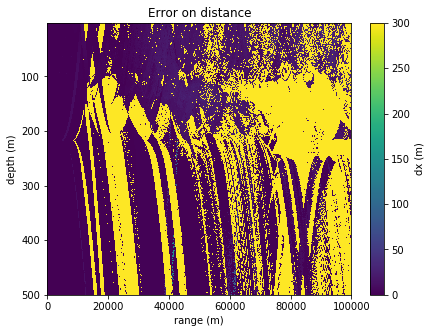

In [47]:
# dx table
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.pcolormesh(R, Z, abs(dx2[:,:,isd]).T) #, cmap='jet')
plt.title ('Error on distance')
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("dx (m)")
plt.clim([0,300])
plt.gca().invert_yaxis()

# Pourcents
tot = dx2.shape[0]*dx2.shape[1]
under10 = np.where(abs(dx2) <10.)[0].shape[0]
under50 = np.where(np.logical_and(abs(dx2) >=10., abs(dx2) < 50.))[0].shape[0]
over50  = np.where(abs(dx2) >= 50.)[0].shape[0]
print ('dx < 10m : %.1f' %(under10/tot*100.) + '%')
print ('10m < dx < 50m : %.1f' %(under50/tot*100.) + '%')
print ('dx > 50m : %.1f' %(over50/tot*100.) + '%')

### Ray comparison

In [30]:
# 3 PROFILES : Generate .env and .ssp file R
s.params['NBeams'] = 20
s.params['hypothesis'] = 'QVWT'       # Q for quadrilateral SSP interpolation (SSP2D)
s.params['file_type'] = 'R'
s.params['ALimites'] = [-7,7]         # limit angles

s.generate_envfile('gs',file_env = 'gs_2D_R_3prof.env', Issp=issp, SSP_depth_step=1, c = c_3profiles[0,:])
s.generate_sspfile('gs', file_env='gs_2D_R_3prof.env', SSP_depth_step=1, r = r_3profiles, c = c_3profiles)

Output file is : gs_2D_R_3prof.ssp


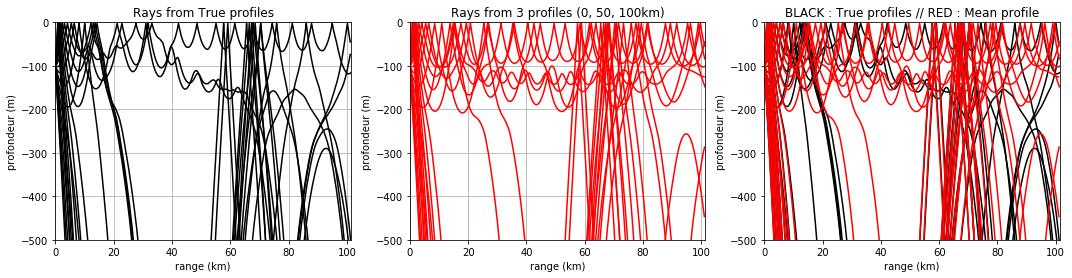

In [31]:
plt.figure(figsize=(18,4))
plt.subplot(131)
s.plotray('files_2D/gs_2D_R.ray', colors='k', zoom=True)
plt.title('Rays from True profiles')
plt.subplot(132)
s.plotray('files_2D/gs_2D_R_3prof.ray', colors='r', zoom=True)
plt.title('Rays from 3 profiles (0, 50, 100km)')
plt.subplot(133)
s.plotray('files_2D/gs_2D_R.ray', colors='k', zoom=True)
s.plotray('files_2D/gs_2D_R_3prof.ray', colors='r', zoom=True)
plt.title('BLACK : True profiles // RED : Mean profile')
plt.show()

---
# With 6 profiles(one every 20km)

In [32]:
# ranges 0km, 20km, 40km, 60km, 80km and 107km 
c_6profiles = np.vstack((c[0,:],c[41,:],c[81,:],c[121,:],c[161,:],c[215,:]))
r_6profiles = np.array([r[0], r[41],r[81],r[121],r[161], r[215]]) 

In [33]:
# Generate .env file A and .ssp file
s.params['hypothesis'] = 'QVWT'
s.generate_envfile('gs',file_env = 'gs_2D_A_6prof.env', Issp=issp, SSP_depth_step=1, c = c_6profiles[0,:])
s.generate_sspfile('gs', file_env='gs_2D_A_6prof.env', SSP_depth_step=1, r = r_6profiles, c = c_6profiles)

Output file is : gs_2D_A_6prof.ssp


In [34]:
### read file .arr 
#Arr_6prof, Pos_6prof = s.read_arrivals_asc ('gs_2D_A_6prof.arr', Narrmx = 15)
Arr_6prof, Pos_6prof = s.load_dict('../Dictio', 'Arr_gs_6prof'), s.load_dict('../Dictio', 'Pos_gs_6prof')

In [35]:
#T_6prof = time_table(Arr_6prof)
#np.save('T_6prof', T_6prof)
T_6prof = np.load('NPY_2D/T_6prof.npy')

In [48]:
diff_T6 = T_true - T_6prof
dx6 = diff_T6 * celerity

dx < 10m : 56.3%
10m < dx < 50m : 13.5%
dx > 50m : 37.7%


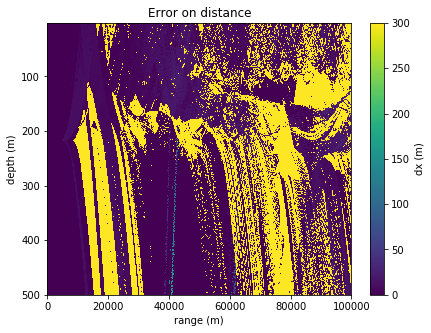

In [49]:
# dx table
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.pcolormesh(R, Z, abs(dx6[:,:,isd]).T) #, cmap='jet')
plt.title ('Error on distance')
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("dx (m)")
plt.clim([0,300])
plt.gca().invert_yaxis()

# Pourcents
tot = dx6.shape[0]*dx6.shape[1]
under10 = np.where(abs(dx6) <10.)[0].shape[0]
under50 = np.where(np.logical_and(abs(dx6) >=10., abs(dx6) < 50.))[0].shape[0]
over100  = np.where(abs(dx6) >= 50.)[0].shape[0]
print ('dx < 10m : %.1f' %(under10/tot*100.) + '%')
print ('10m < dx < 50m : %.1f' %(under50/tot*100.) + '%')
print ('dx > 50m : %.1f' %(over50/tot*100.) + '%')

### Ray comparison 

In [38]:
# 6 PROFILES : Generate .env and .ssp file R
s.params['NBeams'] = 20
s.params['hypothesis'] = 'QVWT'       # Q for quadrilateral SSP interpolation (SSP2D)
s.params['file_type'] = 'R'
s.params['ALimites'] = [-7,7]         # limit angles

s.generate_envfile('gs',file_env = 'gs_2D_R_6prof.env', Issp=issp, SSP_depth_step=1, c = c_6profiles[0,:])
s.generate_sspfile('gs', file_env='gs_2D_R_6prof.env', SSP_depth_step=1, r = r_6profiles, c = c_6profiles)

Output file is : gs_2D_R_6prof.ssp


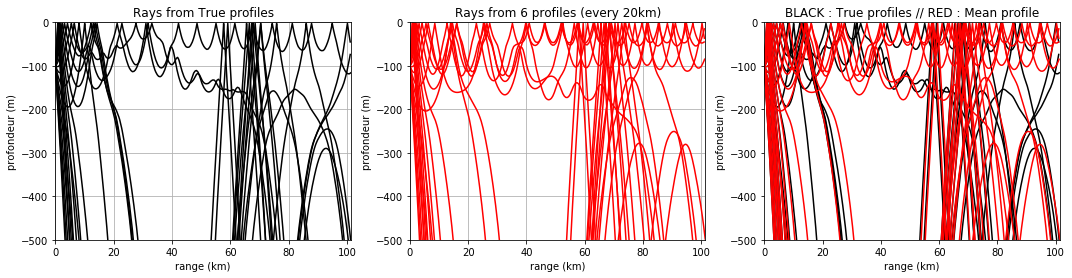

In [39]:
plt.figure(figsize=(18,4))
plt.subplot(131)
s.plotray('files_2D/gs_2D_R.ray', colors='k', zoom=True)
plt.title('Rays from True profiles')
plt.subplot(132)
s.plotray('files_2D/gs_2D_R_6prof.ray', colors='r', zoom=True)
plt.title('Rays from 6 profiles (every 20km)')
plt.subplot(133)
s.plotray('files_2D/gs_2D_R.ray', colors='k', zoom=True)
s.plotray('files_2D/gs_2D_R_6prof.ray', colors='r', zoom=True)
plt.title('BLACK : True profiles // RED : Mean profile')
plt.show()

---
# Zone à grande variabilité (tourbillon)

1 grid file found, uses: /home/datawork-lops-osi/jgula/NESED/nesea_grd.nc
-- Grid object
dim lon_rho: 1602  2002
lon_rho min= -72.123, max=-58.273
lat_rho min= 34.123, max=43.734
h min= 20.000, max=5543.070
Uses the following output file: /home/datawork-lops-osi/jgula/NESED/nesed_avg.00060.nc
The transect will contain 234 horizontal points


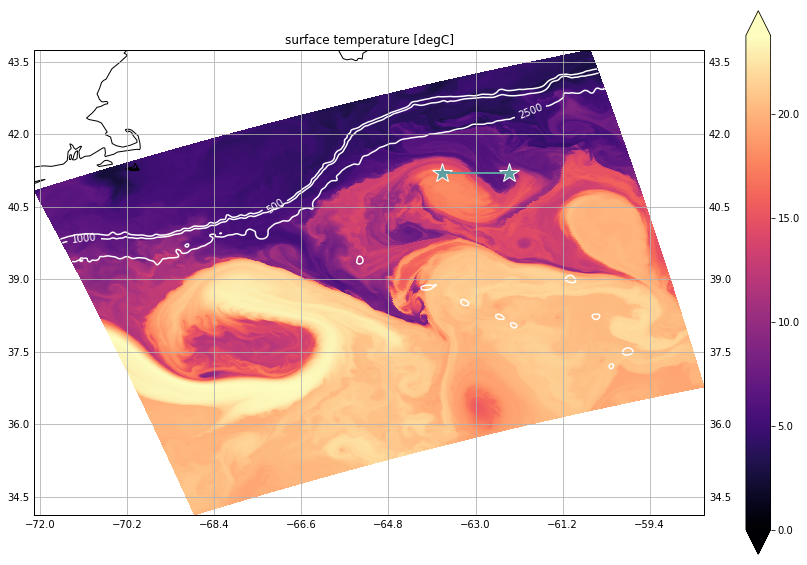

In [60]:
s1 = bellhop({'gs': {'datadir': '/home/datawork-lops-osi/jgula/NESED/', 'lon': [-63.7,-62.3], \
                    'lat': [41.2,41.2], 'plot_map': True, 'contour':True}}, zmax = 4900)

In [61]:
r1 = s1.SSP['gs']['s']              # range (m)
depth1 = s1.SSP['gs']['depth'][:]   # depth (m)
c1 = s1.SSP['gs']['c']              # celerity (m/s)
print('Number of values for each profile :', c1.shape[1])
print('Number of celerity profiles :', c1.shape[0])
print('Maximum range : %.1fkm' %(np.max(r1[:-1])/1000.))

Number of values for each profile : 50
Number of celerity profiles : 234
Maximum range : 116.4km


In [62]:
# Generate .env file A
issp=0                                # sound speed profile number

s1.params['hypothesis'] = 'QVWT'       # Q for quadrilateral SSP interpolation (SSP2D)
s1.params['file_type'] = 'A'           # 'E' : eigen rays (.rau) / 'A' : arrivals time and amplitude file (.arr)
s1.params['zs'] = 100.                 # source depth
s1.params['ALimites'] = [-89.0, 89.0]  # limit angles

s1.params['NDepth'] = 501              # number of receiver depths
s1.params['zmin'] = 0.                 # minimum depth (m)
s1.params['zmax'] = 500.               # maximum depth (m) (unuseful if NDepth=1)
                 
s1.params['NRange'] = 10001            # number of receiver range    
s1.params['rmin'] = 0.                 # minimum range (km)
s1.params['rmax'] = 100.               # maximum range (km) (unuseful if NRange=1)            

s1.params['zbox'] = 5000.              # box depth limit 
s1.params['rbox'] = 101.               # box range limit 

s1.generate_envfile('gs',file_env = 'gs1_2D_A.env', Issp=issp, SSP_depth_step=1)

In [63]:
s1.generate_sspfile('gs', file_env='gs1_2D_A.env', SSP_depth_step=1)

Output file is : gs1_2D_A.ssp


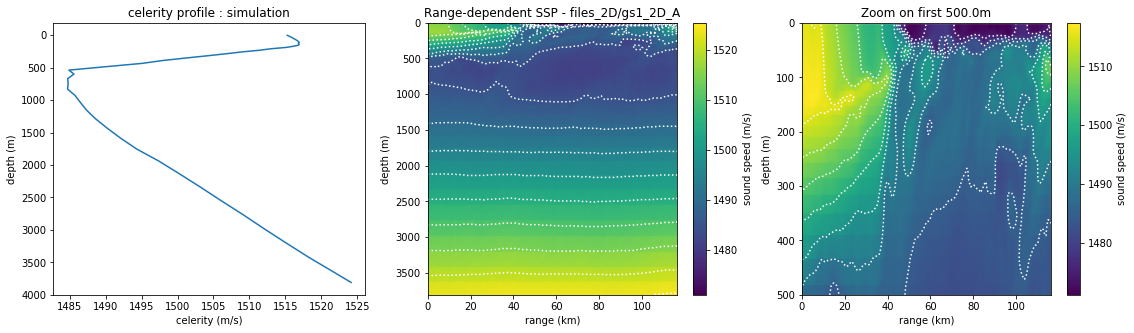

In [64]:
plt.figure(figsize=(19,5))
plt.subplot(131)
s1.plotssp ('gs', Issp=0, zoom=False)
plt.subplot(132)
s1.plotssp2D('files_2D/gs1_2D_A.ssp')
plt.subplot(133)
s1.plotssp2D('files_2D/gs1_2D_A.ssp', zoom = 550.)
plt.show()

In [65]:
Temp1 = np.flipud(s1.SSP['gs']['Temp'])
Sal1 = np.flipud(s1.SSP['gs']['Sal'])

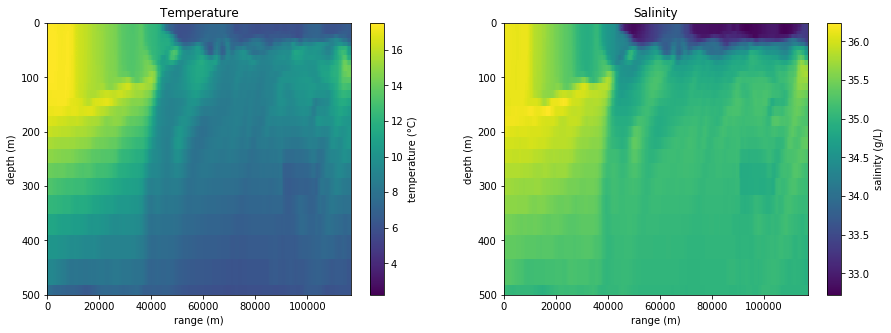

In [66]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.pcolormesh(r1, depth1, Temp1)
plt.title ('Temperature')
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("temperature (°C)")
plt.ylim([0,500])
plt.gca().invert_yaxis()

plt.subplot(122)
plt.pcolormesh(r1, depth1, Sal1)
plt.title ('Salinity')
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("salinity (g/L)")
plt.ylim([0,500])
plt.gca().invert_yaxis()
plt.show()

In [67]:
### read file .arr 
#Arr1, Pos1 = s.read_arrivals_asc ('gs1_2D_A.arr', Narrmx = 15)
#s.save_dict('../Dictio', Arr, 'Arr_gs1_SSP2D')
#s.save_dict('../Dictio', Pos, 'Pos_gs1_SSP2D')
Arr1, Pos1 = s.load_dict('../Dictio', 'Arr_gs1_SSP2D'), s.load_dict('../Dictio', 'Pos_gs1_SSP2D')

Max.number of arrivals for source index 0 is 10


In [73]:
#T_true1 = time_table(Arr1)
#np.save('T_true1', T_true1)
T_true1 = np.load ('NPY_2D/T_true1.npy')

In [75]:
### Generate .env file A
s.params['file_type'] = 'A'
s.params['hypothesis'] = 'SVWT' 
s.generate_envfile('gs',file_env = 'gs1_1prof_A.env', Issp=issp, SSP_depth_step=1, c = c1[100,:])

In [76]:
### read file .arr 
#Arr1_1prof, Pos1_1prof = s.read_arrivals_asc ('gs1_1prof_A.arr', Narrmx = 15)
#s1.save_dict ('../Dictio', Arr1_1prof, 'Arr1_gs_1prof')
#s1.save_dict ('../Dictio', Pos1_1prof, 'Pos1_gs_1prof')
Arr1_1prof, Pos1_1prof = s.load_dict('../Dictio', 'Arr1_gs_1prof'), s.load_dict('../Dictio', 'Pos1_gs_1prof')

Max.number of arrivals for source index 0 is 10


In [110]:
#T1_1prof = time_table(Arr1_1prof)
#np.save('T1_1prof', T1_1prof)
T1_1prof = np.load('NPY_2D/T1_1prof.npy')

In [111]:
diff1_1prof = T_true1 - T1_1prof
celerity = 1500. 
dx1 = diff1_1prof * celerity

dx < 10m : 1.0%
10m < dx < 50m : 6.1%
dx > 50m : 91.2%


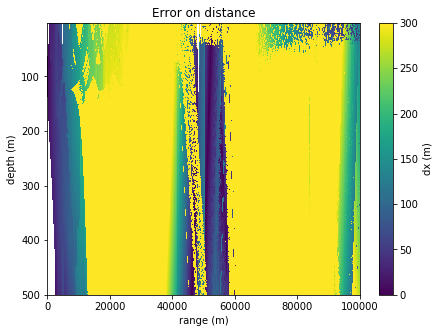

In [115]:
# dx table
plt.figure(figsize=(7,5))
plt.pcolormesh(R, Z, abs(dx1[:,:,isd]).T) #, cmap='jet')
plt.title ('Error on distance')
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("dx (m)")
plt.clim([0,300])
plt.gca().invert_yaxis()

# Pourcents
tot = dx1.shape[0]*dx1.shape[1]
under10 = np.where(abs(dx1) <10.)[0].shape[0]
under50 = np.where(np.logical_and(abs(dx1) >=10., abs(dx1) < 50.))[0].shape[0]
over50  = np.where(abs(dx1) >= 50.)[0].shape[0]
print ('dx < 10m : %.1f' %(under10/tot*100.) + '%')
print ('10m < dx < 50m : %.1f' %(under50/tot*100.) + '%')
print ('dx > 50m : %.1f' %(over50/tot*100.) + '%')

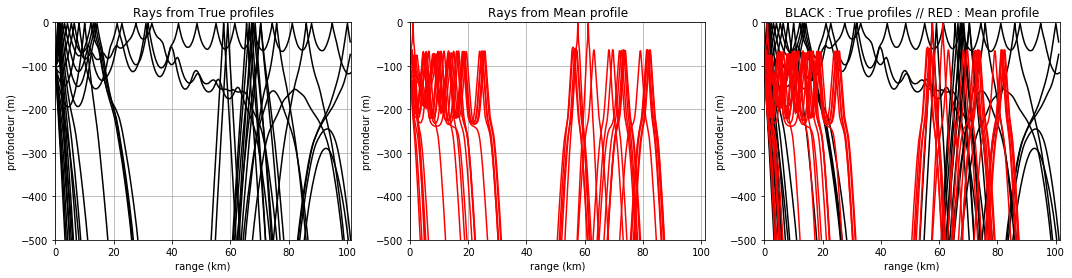

In [83]:
plt.figure(figsize=(18,4))
plt.subplot(131)
s.plotray('files_2D/gs1_2D_R.ray', colors='k', zoom=True)
plt.title('Rays from True profiles')
plt.subplot(132)
s.plotray('files_2D/gs1_1prof_R.ray', colors='r', zoom=True)
plt.title('Rays from Mean profile')
plt.subplot(133)
s.plotray('files_2D/gs1_2D_R.ray', colors='k', zoom=True)
s.plotray('files_2D/gs1_1prof_R.ray', colors='r', zoom=True)
plt.title('BLACK : True profiles // RED : Mean profile')
plt.show()

## Annexe : Mean profile

#### Time table calculation

In [ ]:
mean_profile = np.zeros(c.shape[1])
diff_max = np.zeros(c.shape[1])
for i in range(c.shape[1]) : 
    mean_profile[i] = np.mean(c[:,i])
    diff_max[i] = np.max(c[:,i]) - np.min(c[:,i])

print('Maximum celerity variation between profiles is equal to %.1fm/s.' %np.max(diff_max))

In [ ]:
### Generate .env file A
#s.params['hypothesis'] = 'SVWT' 
#s.generate_envfile('gs',file_env = 'gs_mean_A.env', Issp=issp, SSP_depth_step=1, c = mean_profile)

In [ ]:
### read file .arr 
#Arr_mean, Pos_mean = s.read_arrivals_asc ('gs_mean_A.arr', Narrmx = 15)
#s.save_dict('../Dictio', Arr, 'Arr_gs_mean')
#s.save_dict('../Dictio', Pos, 'Pos_gs_mean')
Arr_mean, Pos_mean = s.load_dict('../Dictio', 'Arr_gs_mean'), s.load_dict('../Dictio', 'Pos_gs_mean')

In [ ]:
#T_mean = time_table(Arr_mean)
#np.save('T_mean', T_mean)
T_mean = np.load ('NPY_2D/T_mean.npy')

#### Error on distance

In [47]:
diff_T = T_true - T_mean
celerity = 1500. 
dxM = diff_T * celerity

dx < 10m : 35.5%
10m < dx < 50m : 13.3%
dx > 50m : 37.7%


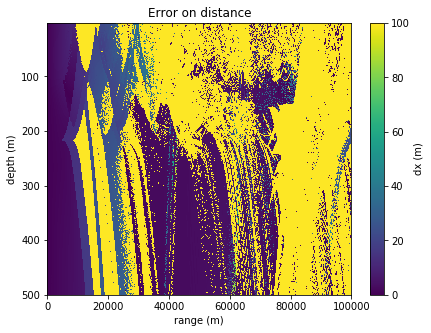

In [42]:
# dx table
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.pcolormesh(R, Z, abs(dxM[:,:,isd]).T) #, cmap='jet')
plt.title ('Error on distance')
plt.xlabel("range (m)")
plt.ylabel("depth (m)")
cbar = plt.colorbar()
cbar.set_label("dx (m)")
plt.clim([0,300])
plt.gca().invert_yaxis()

# Pourcents
tot = dxM.shape[0]*dxM.shape[1]
under10 = np.where(abs(dxM) <10.)[0].shape[0]
under50 = np.where(np.logical_and(abs(dxM) >=10., abs(dxM) < 50.))[0].shape[0]
over100  = np.where(abs(dxM) >= 50.)[0].shape[0]
print ('dx < 10m : %.1f' %(under10/tot*100.) + '%')
print ('10m < dx < 50m : %.1f' %(under50/tot*100.) + '%')
print ('dx > 50m : %.1f' %(over50/tot*100.) + '%')

#### Ray comparison 

In [49]:
# TRUE : Generate .env and .ssp file R
s.params['NBeams'] = 20
s.params['hypothesis'] = 'QVWT'       # Q for quadrilateral SSP interpolation (SSP2D)
s.params['file_type'] = 'R'
s.params['ALimites'] = [-7,7]
s.generate_envfile('gs',file_env = 'gs_2D_R.env', Issp=issp, SSP_depth_step=1)
s.generate_sspfile('gs', file_env='gs_2D_R.env', SSP_depth_step=1)

### MEAN : Generate .env file R
s.params['hypothesis'] = 'SVWT' 
s.generate_envfile('gs',file_env = 'gs_mean_R.env', Issp=issp, SSP_depth_step=1, c = mean_profile)

Output file is : gs_2D_R.ssp


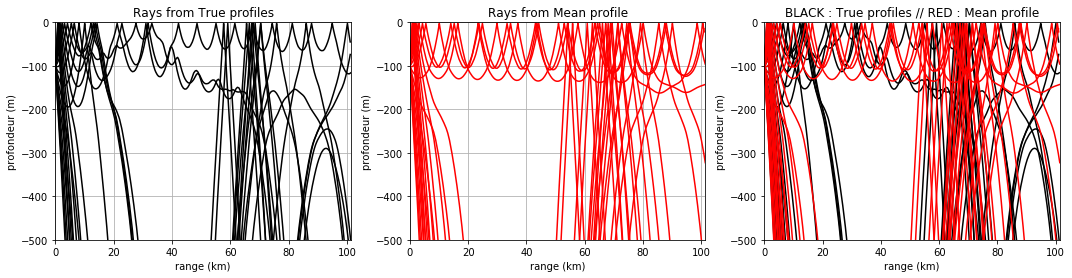

In [50]:
plt.figure(figsize=(18,4))
plt.subplot(131)
s.plotray('files_2D/gs_2D_R.ray', colors='k', zoom=True)
plt.title('Rays from True profiles')
plt.subplot(132)
s.plotray('files_2D/gs_mean_R.ray', colors='r', zoom=True)
plt.title('Rays from Mean profile')
plt.subplot(133)
s.plotray('files_2D/gs_2D_R.ray', colors='k', zoom=True)
s.plotray('files_2D/gs_mean_R.ray', colors='r', zoom=True)
plt.title('BLACK : True profiles // RED : Mean profile')
plt.show()